In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
from sqlalchemy import inspect

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of column names and types for the measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Get a list of column names and types for the station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Pull everything from the measurement table
sel = [Measurement.prcp, Measurement.date]
all_dates = session.query(*sel).all()

In [14]:
len(all_dates), all_dates[0], all_dates[-1]

(19550, (0.08, '2010-01-01'), (0.45, '2017-08-23'))

In [15]:
# One way to get the first date and last dates in the database
query_results = session.query(func.min(Measurement.date), func.max(Measurement.date)).all()

for min_date, max_date in query_results:
    print(f"The earliest date in the table is: {min_date}")
    print(f"The latest date in the table is: {max_date}")
    print(f"The dates are stored as type: {type(min_date)}")

The earliest date in the table is: 2010-01-01
The latest date in the table is: 2017-08-23
The dates are stored as type: <class 'str'>


In [16]:
# Another way to get the first and last dates in the datebase
# The first date in the database
date_range = [(session.query(Measurement.date).order_by(Measurement.date).first()[0],\
              session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0])]

for min_date, max_date in date_range:
    print(f"The earliest date in the table is: {min_date}")
    print(f"The latest date in the table is: {max_date}")
    print(f"The dates are stored as type: {type(min_date)}")

The earliest date in the table is: 2010-01-01
The latest date in the table is: 2017-08-23
The dates are stored as type: <class 'str'>


In [17]:
# timedelta ignores leap years (need to use relativedelta instead)
# but for our problem there is no difference.
# There would be a diffence if we were working with longer timespans
# from dateutil.relativedelta import relativedelta

# print(f"One year ago using relativedelta: {last_date - relativedelta(years=1)}")
# print(f"One year ago using timedelta: {last_date - dt.timedelta(days=365)}")
# print("")
# print(f"Six years ago using relativedelta: {last_date - relativedelta(years=6)}")
# print(f"Six years ago using timedelta: {last_date - dt.timedelta(days=6*365)}")

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The last date in the database: {last_date}")
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
print(f"The last date as a datetime object {last_date}")

# Calculate the date 1 year ago from the last data point in the database
# For longer timespans we would need to use dateutil.relativedelta to handle leap years
one_year_ago = last_date - dt.timedelta(days=365)
print(f"One year ago as a datetime object: {one_year_ago}")
one_year_ago_str = one_year_ago.strftime("%Y-%m-%d")
print(f"One year ago as a string: {one_year_ago_str}")

# Perform a query to retrieve the data and precipitation scores
# This gives different results depending on whether I use 
# one_year_ago as a datetime object or one_year_ago_str as a string
last_years_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago_str).all()
print(f"The length of the pull is: {len(last_years_data)}")

last_years_data_dt = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()
print(f"The length of the pull is: {len(last_years_data_dt)}")


df_str = pd.DataFrame(last_years_data, columns=["Date", "Precipitation"])
df_str.set_index('Date', inplace=True)
df_str.sort_index(inplace=True)

df_dt = pd.DataFrame(last_years_data_dt, columns=["Date", "Precipitation"])
df_dt.set_index('Date', inplace=True)
df_dt.sort_index(inplace=True)

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


The last date in the database: 2017-08-23
The last date as a datetime object 2017-08-23 00:00:00
One year ago as a datetime object: 2016-08-23 00:00:00
One year ago as a string: 2016-08-23
The length of the pull is: 2230
The length of the pull is: 2223


In [19]:
def compare_dataframes(df1, df2):
    """
    Args:  df1, df2 are pandas dataframes of differing row counts.  Returns the first row of df1 where df1 != df2
    otherwise, returns Null
    """
    index = 0
    for df1_row, df2_row in zip(df1.itertuples(), df2.itertuples()):
        if df1_row != df2_row:
            return(index, df1_row)
        index += 1

compare_dataframes(df_str, df_dt)

(0, Pandas(Index='2016-08-23', Precipitation=0.0))

In [20]:
(df_str.iloc[0], df_dt.iloc[0])

(Precipitation    0.0
 Name: 2016-08-23, dtype: float64, Precipitation    0.08
 Name: 2016-08-24, dtype: float64)

In [21]:
df_dt_small = df_dt.iloc[:200,]
df_dt_small.shape

(200, 1)

In [ ]:
# ax = df_dt_small.plot.bar(stacked=True)
#subplot = df_dt.plot(kind='bar')
#ax = subplot.axes
#ax.set_xticks([])       # Alternatively, you can manually adjust the 
#ax.set_xticklabels([])   # or their labels
#df_str.plot.bar()
#plt.tight_layout()
#plt.figure(figsize=(10,10))
#plt.show()
#plt.show()

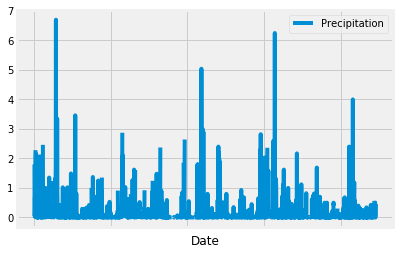

In [22]:
df_str.plot()

In [23]:
df_str.iloc[:10,]

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15


In [24]:
df_dt.iloc[:10,]

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
2016-08-24,1.22
2016-08-25,0.08
2016-08-25,0.00


In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# This matches the starter notebook.
df_str.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [27]:
# Design a query to show how many stations are available in this dataset?
query_results = session.query(Measurement.station).distinct().all()
print(query_results)

from sqlalchemy import distinct
session.query(func.count(distinct(Measurement.station))).scalar()

[('USC00519397',), ('USC00513117',), ('USC00514830',), ('USC00517948',), ('USC00518838',), ('USC00519523',), ('USC00519281',), ('USC00511918',), ('USC00516128',)]


9

In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# The most active station:
most_active = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]
most_active

'USC00519281'

In [30]:
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


[(54.0, 85.0, 71.66378066378067)]

In [ ]:
# Question for me - is the station with the highest number of temparture dates also the most
# active station?  - How many tobs are null/missing?

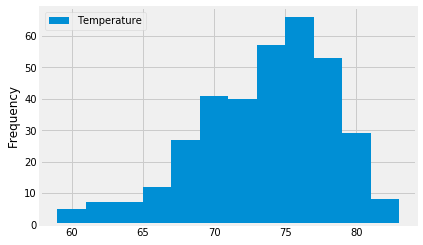

In [31]:
query_results = session.query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago_str).\
    filter(Measurement.station == most_active).all()

#query_results[:10]
df_temp = pd.DataFrame(query_results, columns=['Temperature'])
df_temp.plot.hist(bins=12) # default is bins=10, bins=12 matches the sample graph

In [1]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [97]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [110]:
temps = calc_temps('2017-01-01', '2017-01-07') # The dates that match the provided output
temps

[(62.0, 68.36585365853658, 74.0)]

In [115]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
max(temps[0])

74.0

<function matplotlib.pyplot.show(*args, **kw)>

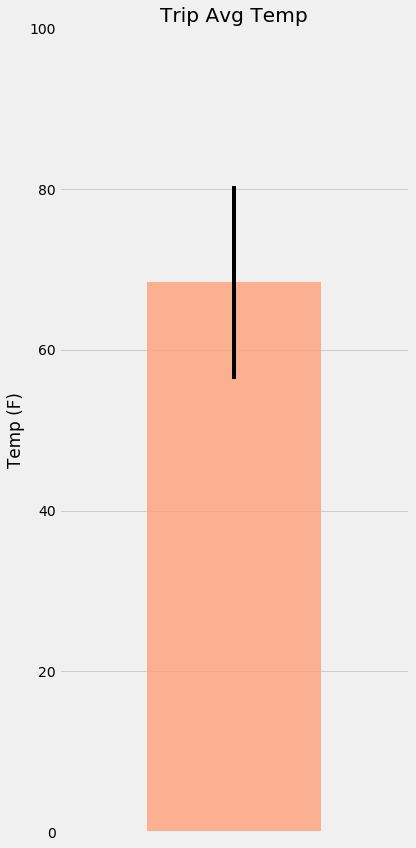

In [147]:
import numpy as np

yerr = [max(temps[0])-min(temps[0])]

df_summary_temps = pd.DataFrame(temps, columns = ['tmin', 'tavg', 'tmax'])
ax = df_summary_temps['tavg'].plot(kind='bar',yerr=yerr,color="lightsalmon",figsize=(6,12),alpha=0.8)
ax.set_title('Trip Avg Temp')
ax.set_xticklabels([])
ax.set_ylabel('Temp (F)')
ax.xaxis.grid(False)
ylim = [0, 100]
ax.set_ylim(0,100)

# Save the figure and show
plt.tight_layout()
plt.show

In [ ]:
# Note the plot below could not have been produced using the 'tavg' given above - it appears to be produced using 'tmax'.

<IPython.core.display.Javascript object>


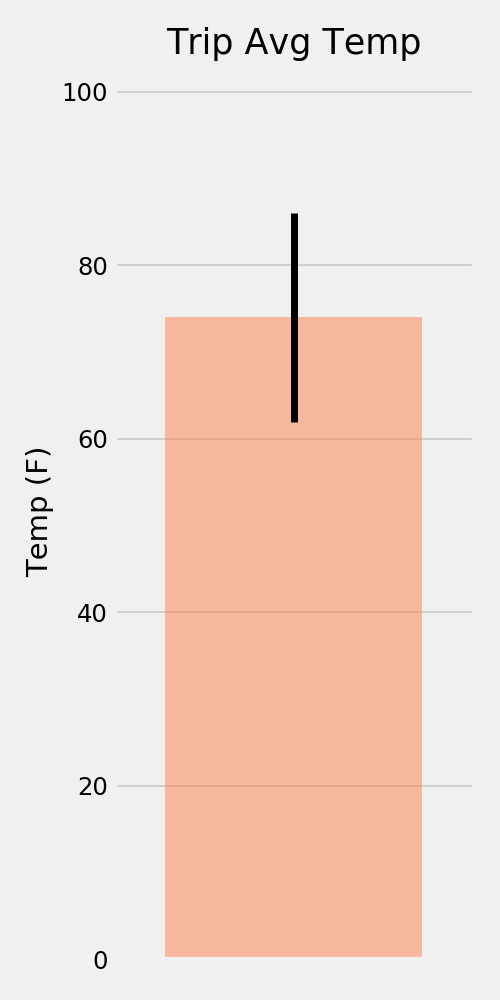

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [218]:
# 
def one_year_ago(a_date, date_format="%Y-%m-%d"):
    """
    Args: a_date is a string date the the time-format specified in date_format (default is %Y-%m-%d).  
    Returns: a string date in the same format for one year (365 days) prior.
    """
    a_date = dt.datetime.strptime(a_date, date_format)
    return a_date - dt.timedelta(days=365)

start_date = "2018-01-01"
end_date = "2018-01-07"

start_delta = one_year_ago(start_date)
end_delta = one_year_ago(end_date)

print(start_date, start_delta)
print(end_date, end_delta)

2018-01-01 2017-01-01 00:00:00
2018-01-07 2017-01-07 00:00:00


In [219]:
query_results = session.query(Station.station).all()
for row in query_results:
    print(row)

('USC00519397',)
('USC00513117',)
('USC00514830',)
('USC00517948',)
('USC00518838',)
('USC00519523',)
('USC00519281',)
('USC00511918',)
('USC00516128',)


In [220]:

sel = [Measurement.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       func.sum(Measurement.prcp)]

query_results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_delta).\
    filter(Measurement.date <= end_delta).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

for row in query_results:
    print(row)

('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.61)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.6)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.57)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.16999999999999998)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.06)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)


In [222]:
# This only gives 6 stations and it depends on whether I pass in a datetime object or a string date.
# 
sel = [Measurement.date,
       Measurement.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       Measurement.prcp]

query_results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_delta).\
    filter(Measurement.date <= end_delta).all()

for row in query_results:
    print(row)

('2017-01-02', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-03', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-04', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-05', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-06', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-07', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-02', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)
('2017-01-03', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)
('2017-01-04', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)
('2017-01-05', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)
('2017-01-06', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)
('2017-01-07', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.801

In [223]:
# This only gives 6 stations and it depends on whether I pass in a datetime object or a string date.
# 
sel = [Measurement.date,
       Measurement.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       Measurement.prcp]

query_results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= '2017-01-01').\
    filter(Measurement.date <= '2017-01-07').all()

for row in query_results:
    print(row)

('2017-01-01', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-02', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-03', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-04', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-05', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-06', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-07', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('2017-01-01', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29)
('2017-01-02', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)
('2017-01-03', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)
('2017-01-04', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0)
('2017-01-05', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.801

In [224]:
# You can get all 9 by not filtering on time.
sel = [Measurement.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       func.sum(Measurement.prcp)]

query_results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

for row in query_results:
    print(row)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1068.0899999999956)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 588.6399999999976)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 382.61999999999847)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 295.67999999999944)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 234.49000000000026)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 131.62000000000063)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 92.68000000000006)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 70.87000000000005)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 43.44000000000002)


In [230]:
# This only gives 6 stations and it depends on whether I pass in a datetime object or a string date.
# So I am trying a left outer join to get all the missing stations - still doesn't work.
# does it work with the sum function?

sel = [Station.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       Measurement.prcp,
      Measurement.date]

query_results = session.query(*sel).\
    join(Measurement, Measurement.station == Station.station, isouter=True).\
    filter(Measurement.date >= '2017-01-01').\
    filter(Measurement.date <= '2017-01-07').all()

for row in query_results:
    print(row)

('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0, '2017-01-01')
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0, '2017-01-02')
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0, '2017-01-03')
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0, '2017-01-04')
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0, '2017-01-05')
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0, '2017-01-06')
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0, '2017-01-07')
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29, '2017-01-01')
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0, '2017-01-02')
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0, '2017-01-03')
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0, '2017-01-04')
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0, 

In [233]:
# We can see that in 2017, two of the stations do not have any recordings.
dropped_obs = ['USC00517948', 'USC00518838', 'USC00511918']

sel = [Station.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       Measurement.prcp,
      Measurement.date]

query_results = session.query(*sel).\
    join(Measurement, Measurement.station == Station.station, isouter=True).\
    filter(Measurement.date >= '2017-01-01').\
    filter(Station.station.in_(dropped_obs)).all()

print(len(query_results))
for row in query_results:
    print(row)

107
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None, '2017-01-09')
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None, '2017-01-10')
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None, '2017-01-11')
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None, '2017-01-12')
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None, '2017-01-13')
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0, '2017-01-17')
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0, '2017-01-18')
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None, '2017-01-19')
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None, '2017-01-20')
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None, '2017-01-23')
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None, '2017-01-24')
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None, '2017-01-25')
('

In [235]:
# The following query gets at the heart of the problem.  We do not have observations after 2016 for two of the stations.

sel = [Station.station,
       Station.name,
       func.min(Measurement.date),
       func.max(Measurement.date)]

query_results = session.query(*sel).\
    join(Measurement, Measurement.station == Station.station, isouter=True).\
    group_by(Station.station).all()

for row in query_results:
    print(row)

('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', '2010-01-01', '2015-10-30')
('USC00513117', 'KANEOHE 838.1, HI US', '2010-01-01', '2017-07-31')
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', '2010-03-01', '2017-08-23')
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', '2010-01-01', '2017-08-23')
('USC00517948', 'PEARL CITY, HI US', '2010-05-03', '2017-07-31')
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', '2010-01-01', '2015-11-20')
('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-01', '2017-08-18')
('USC00519397', 'WAIKIKI 717.2, HI US', '2010-01-01', '2017-08-23')
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', '2010-01-01', '2017-08-23')


In [238]:
sel = [Measurement.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       func.ifnull(func.sum(Measurement.prcp), 0)]

query_results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_delta).\
    filter(Measurement.date <= end_delta).\
    group_by(Measurement.station).\
    order_by(func.ifnull(func.sum(Measurement.prcp), 0).desc()).all()

for row in query_results:
    print(row)

('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.61)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.6)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.57)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.16999999999999998)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.06)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [239]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [246]:
import datetime as dt

In [271]:
start_date_dt = dt.datetime.strptime(start_date, "%Y-%m-%d")
end_date_dt = dt.datetime.strptime(end_date, "%Y-%m-%d")

full_dates = [start_date_dt.strftime("%Y-%m-%d")]
dates = [start_date_dt.strftime("%m-%d")]
current_date = start_date_dt
while (current_date <= end_date_dt):
        full_dates.append(current_date.strftime("%Y-%m-%d"))
        dates.append(current_date.strftime("%m-%d"))
        current_date = current_date + dt.timedelta(days=1)

print(full_dates, dates)

normals = [daily_normals(date)[0] for date in dates]
print(normals)

normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
normals_df['date'] = full_dates
#normals_df
normals_df.set_index('date', inplace=True)
normals_df

['2018-01-01', '2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06', '2018-01-07'] ['01-01', '01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07']
[(62.0, 69.15384615384616, 77.0), (62.0, 69.15384615384616, 77.0), (60.0, 69.39622641509433, 77.0), (62.0, 68.9090909090909, 77.0), (58.0, 70.0, 76.0), (56.0, 67.96428571428571, 76.0), (61.0, 68.96491228070175, 76.0), (57.0, 68.54385964912281, 76.0)]


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


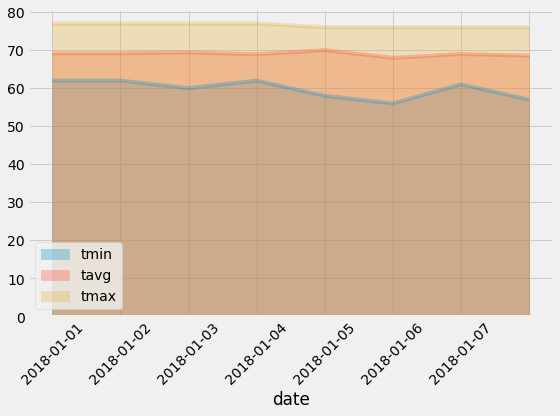

In [286]:
ax = normals_df.plot.area(stacked=False, alpha = 0.3, figsize=(8,6))
ax.set_xticklabels(normals_df.index, rotation=45)
plt.tight_layout()
#plt.xticks(rotation=45)

In [282]:
# Plot the daily normals as an area plot with `stacked=False`
